In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-dialectal/ML_cleaned_train.csv
/kaggle/input/ml-dialectal/ML_cleaned_test.csv


## Introduction

    The objective of this project is to build a machine learning model to predict the dialect of a given Arabic text.The approach involves preprocessing the data, selecting appropriate features, and training various models to determine the best performer.

In [2]:
import pandas as pd
import numpy as np
import re
import pickle
import xgboost as xgb
import optuna
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [3]:
train_data = pd.read_csv('/kaggle/input/ml-dialectal/ML_cleaned_train.csv')
test_data = pd.read_csv('/kaggle/input/ml-dialectal/ML_cleaned_test.csv')


In [4]:
train_data.head(40)

,Text,Dialect
0,واله بالعكس جو سمح صقع سم لين خلاص,LY
1,ضربتها بالقلايه بكري,LY
2,يا استاذي الفاضل احنا عاصرنا ده محدش حكاهولنا,EG
3,هوينه هانيبال ولد العقيد متزوج لبنانيه عارضه ا...,LY
4,السعاده حضرتك المنشن المحترمين,EG
5,واله فاصوليا بالكرشه الا باهيه الحق,LY
6,رمضان قرب وبدو ايقصو الضي كا العاده,LY
7,الطلاب لوزاره التعليماذا مكنشي النهارده يبقي ب...,EG
8,السنه لعبش كويس حتي انا ضد انه يطلع لمسه,LY
9,يا انت اكل بلوك يا انا اكيد يلي اكل بلوك مين هيدا,LB


## Dialect
    Egyptian (EG)
    Libyan (LY)
    Lebanese (LB)
    Sudanese (SD)
    Moroccan (MA)


In [5]:
dialects = train_data['Dialect'].value_counts()
dialects

Dialect
EG    46062
LY    29156
LB    22069
SD    11508
MA     9219
Name: count, dtype: int64

<Axes: xlabel='Dialect'>

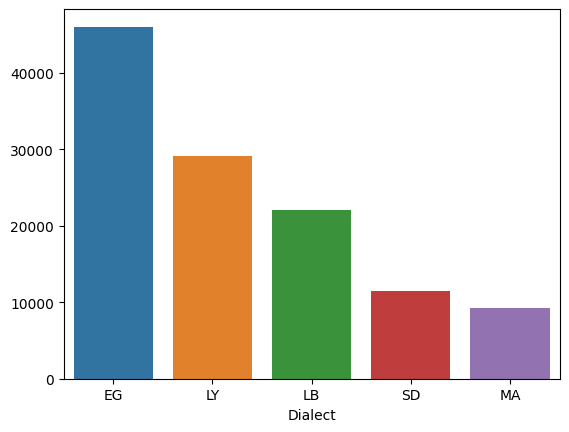

In [6]:
import seaborn as sns 
sns.barplot(x=dialects.index,y=dialects.values)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='text_length', ylabel='Count'>

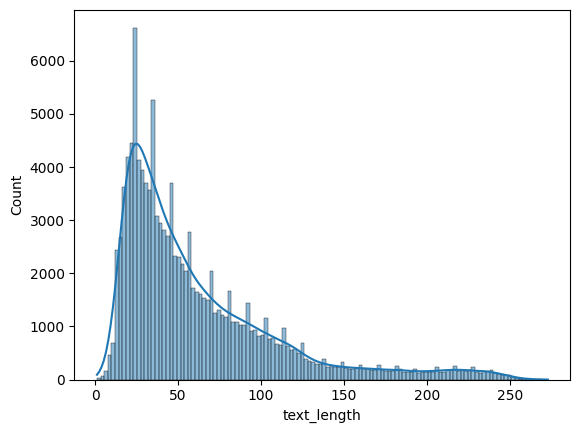

In [7]:
train_data['text_length'] = train_data['Text'].apply(lambda x: len(str(x)))
sns.histplot(train_data['text_length'],kde=True)

In [8]:
train_data.dropna(inplace=True,axis=0)

In [9]:
test_data.dropna(inplace=True,axis=0)

In [10]:
X_train = train_data['Text']
y_train = train_data['Dialect']
X_test = test_data['Text']
y_test = test_data['Dialect']

In [11]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

In [12]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [13]:
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(y_train)
test_labels = label_encoder.transform(y_test)

## Model Training
* Multinomial Naive Bayes
* XGBoost
* Support Vector Machine (SVM) 


In [14]:
nb_model = MultinomialNB()

In [15]:
nb_model.fit(X_train_tfidf,train_labels)

MultinomialNB()

In [16]:
y_pred = nb_model.predict(X_test_tfidf)


In [17]:
accuracy = accuracy_score(test_labels, y_pred)
classification_rep = classification_report(test_labels, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

Accuracy: 0.7887872628726287
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.96      0.83     11522
           1       0.88      0.77      0.82      5523
           2       0.80      0.75      0.77      7293
           3       0.95      0.55      0.69      2307
           4       0.93      0.42      0.58      2875

    accuracy                           0.79     29520
   macro avg       0.86      0.69      0.74     29520
weighted avg       0.81      0.79      0.78     29520



In [18]:
# def objective(trial):
#     # Suggest values for alpha
#     alpha = trial.suggest_float('alpha', 1e-3, 10.0)

#     # Train the Multinomial Naive Bayes model with the suggested alpha
#     nb_model = MultinomialNB(alpha=alpha)
#     nb_model.fit(X_train_tfidf, y_train)

#     # Predict the labels on the validation set
#     y_pred = nb_model.predict(X_test_tfidf)
    
#     # Calculate accuracy
#     accuracy = accuracy_score(y_test, y_pred)
    
#     return accuracy

In [20]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# # Print the best hyperparameters
# print('Best hyperparameters:', study.best_params)

In [ ]:
# best_alpha = study.best_params['alpha']


In [51]:
# best_nb_model = MultinomialNB(alpha=best_alpha)

In [52]:
# best_nb_model.fit(X_train_tfidf, train_labels)


MultinomialNB(alpha=0.32573512382280567)

In [53]:
# y_pred = best_nb_model.predict(X_test_tfidf)


In [54]:
# accuracy = accuracy_score(test_labels, y_pred)
# classification_rep = classification_report(test_labels, y_pred)

# print("Accuracy:", accuracy)
# print("Classification Report:\n", classification_rep)

Accuracy: 0.7939024390243903
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.95      0.83     11522
           1       0.88      0.77      0.82      5523
           2       0.80      0.76      0.78      7293
           3       0.93      0.58      0.71      2307
           4       0.91      0.46      0.61      2875

    accuracy                           0.79     29520
   macro avg       0.85      0.70      0.75     29520
weighted avg       0.81      0.79      0.79     29520



In [23]:
with open('nb_model.pkl', 'wb') as f:
    pickle.dump(nb_model, f)

# Save the model and vectorizer together
with open('tfnb_model.pkl', 'wb') as file:
    pickle.dump((nb_model,tfidf_vectorizer), file)

## Xgboost

In [23]:
gtrain = xgb.DMatrix(X_train_tfidf, train_labels)
gtest = xgb.DMatrix(X_test_tfidf, test_labels)

In [25]:
params = {
    'objective': 'multi:softmax',
    'num_class': len(y_train.unique()),
    'max_depth': 6,
    'eta': 0.3,
    'eval_metric': 'mlogloss'
}

In [27]:
bst = xgb.train(params, gtrain, num_boost_round=100)

In [28]:
y_pred = bst.predict(gtest)


In [31]:
accuracy = accuracy_score(test_labels, y_pred)
classification_rep = classification_report(test_labels, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

Accuracy: 0.7171070460704607
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.85      0.79     11522
           1       0.89      0.62      0.73      5523
           2       0.57      0.76      0.65      7293
           3       0.91      0.50      0.65      2307
           4       0.80      0.44      0.57      2875

    accuracy                           0.72     29520
   macro avg       0.78      0.63      0.68     29520
weighted avg       0.75      0.72      0.71     29520



In [32]:
with open('xgboost_model.pkl','wb') as f:
    pickle.dump('bst',f)

## SVC Model

In [33]:
svm_model = SVC(kernel='linear')

In [34]:
svm_model.fit(X_train_tfidf,train_labels)

SVC(kernel='linear')

In [35]:
y_pred = nb_model.predict(X_test_tfidf)

In [36]:
accuracy = accuracy_score(test_labels, y_pred)
classification_rep = classification_report(test_labels, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

Accuracy: 0.7887872628726287
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.96      0.83     11522
           1       0.88      0.77      0.82      5523
           2       0.80      0.75      0.77      7293
           3       0.95      0.55      0.69      2307
           4       0.93      0.42      0.58      2875

    accuracy                           0.79     29520
   macro avg       0.86      0.69      0.74     29520
weighted avg       0.81      0.79      0.78     29520



In [38]:
with open('svm_model.pkl','wb') as f:
    pickle.dump(svm_model,f)
